![SolidQ](https://antoniosql.github.io/images/SolidQ_Verne.png) 

# Carga de datos y revisión

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt


In [2]:
conn = sqlite3.connect('Tiendas24H.sqlite')
consulta="select c.CodCliente, FechaNacimiento, EstadoCivil, Sexo, IngresosAnuales, N.NivelAcademico, O.Ocupacion, case     when v.CodCliente is null then 0   else 1  end as 'EsCliente' from clientes c inner join NivelAcademico N    on c.NivelAcademico = N.Codigo     inner join Ocupacion O on c.Ocupacion = o.Codigo     left outer join VentasCAB v          on v.codcliente = C.codcliente where c.Codcliente <>'CONTADO'"

df = pd.read_sql_query(consulta,conn)

df.head()

,CodCliente,FechaNacimiento,EstadoCivil,Sexo,IngresosAnuales,NivelAcademico,Ocupacion,EsCliente
0,000020,1976-04-08,M,M,90000.0,Licenciatura,Profesional especializado,1
1,000026,1975-05-14,S,M,60000.0,Licenciatura,Profesional especializado,1
2,000026,1975-05-14,S,M,60000.0,Licenciatura,Profesional especializado,1
3,000026,1975-05-14,S,M,60000.0,Licenciatura,Profesional especializado,1
4,000026,1975-05-14,S,M,60000.0,Licenciatura,Profesional especializado,1


In [3]:
df.dropna(axis=0,inplace=True)

In [4]:
caracteristicas = ["EstadoCivil", "Sexo", "IngresosAnuales","NivelAcademico", "Ocupacion"]
etiqueta="EsCliente"

In [5]:
from sklearn.preprocessing import  LabelEncoder

le=LabelEncoder()
df['EstadoCivil'] = le.fit_transform(df['EstadoCivil'])
df['Sexo'] = le.fit_transform(df['Sexo'])

In [6]:
dum_df = pd.get_dummies(df[caracteristicas], columns=["NivelAcademico","Ocupacion"] )

In [7]:

X, y = dum_df, df[etiqueta]

# Balanceando con SMOTE

In [8]:
from imblearn.over_sampling import SMOTE 
from collections import Counter

In [9]:
print('Distribución Original %s' % Counter(y))
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Distribución balanceada %s' % Counter(y_res))

Distribución Original Counter({1: 10340, 0: 58})
Distribución balanceada Counter({1: 10340, 0: 10340})


In [10]:
from sklearn.model_selection import train_test_split
X_trainres, X_testres, y_trainres, y_testres = train_test_split(X_res, y_res, random_state=0)

# Árboles de Decisión


In [12]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier().fit(X_trainres, y_trainres)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_trainres, y_trainres)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_testres, y_testres)))

Accuracy of Decision Tree classifier on training set: 0.97
Accuracy of Decision Tree classifier on test set: 0.97


In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
pred = clf.predict(X_testres)
print(confusion_matrix(y_testres, pred))
print(classification_report(y_testres, pred))

[[2569   35]
 [ 127 2439]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2604
           1       0.99      0.95      0.97      2566

    accuracy                           0.97      5170
   macro avg       0.97      0.97      0.97      5170
weighted avg       0.97      0.97      0.97      5170



In [19]:
columnas = ["EstadoCivil", "Sexo", "IngresosAnuales","NivelAcademico", "Ocupacion"]
entrada = [[1,1,2500,1,1] ,[1,1,3000,2,2],[1,1,35000,3,3],[1,1,40000,4,4],[1,1,45000,5,5]]

datos=pd.DataFrame(entrada, columns = columnas)

datos_Entrada = pd.get_dummies(datos, columns=["NivelAcademico","Ocupacion"] )


prediccion = clf.predict_proba(datos_Entrada)

In [20]:
prediccion

array([[0.59782609, 0.40217391],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

In [21]:
importancia = clf.feature_importances_

In [22]:

for i,v in enumerate(importancia):
	print('Caracteristica: %0d, Score: %.5f' % (i,v))

Caracteristica: 0, Score: 0.04958
Caracteristica: 1, Score: 0.23608
Caracteristica: 2, Score: 0.24996
Caracteristica: 3, Score: 0.05407
Caracteristica: 4, Score: 0.03517
Caracteristica: 5, Score: 0.08142
Caracteristica: 6, Score: 0.04900
Caracteristica: 7, Score: 0.10702
Caracteristica: 8, Score: 0.00124
Caracteristica: 9, Score: 0.05201
Caracteristica: 10, Score: 0.00819
Caracteristica: 11, Score: 0.05434
Caracteristica: 12, Score: 0.02192


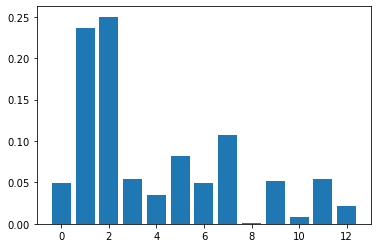

In [23]:
from matplotlib import pyplot

pyplot.bar([x for x in range(len(importancia))], importancia)
pyplot.show()

# Importancia de Características con XGBoost

In [26]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc

from xgboost import XGBClassifier, plot_importance

In [27]:
xgb = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb.fit(X_trainres, y_trainres)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=33,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [28]:
xgb_predictions = xgb.predict(X_testres)

En los modelos no-paramétricos como XGBoost es más dificil interpretar los resultados porque el número total de parámetros no es fijo, y puede crecer con el volumen de datos utilizados para el entrenamiento. Los modelos paramétricos (como la regresión logística) ofrece un primer nivel de interpretación por como utiliza los coeficientes. Para contrarrestarlo la mayoría de los algoritmos no-paramétricos proporcionan de forma nativa métodos de interpretación, como la importancia de características, que nos pueden ayudar a entender la evaluación interna que el modelo realiza para hacer sus predicciones



En el caso de XGBoost, la importancia de características global que proporciona de forma nativa está basada en tres parámetros:

Feature Weights: basado en el número de veces que una característica aparece en un árbol entre el ensamblado de árboles
Coverage: La media del número de muestras afectadas por splits que utiliza la característica.
Gain: La ganancia media de splits que utilizan la característica

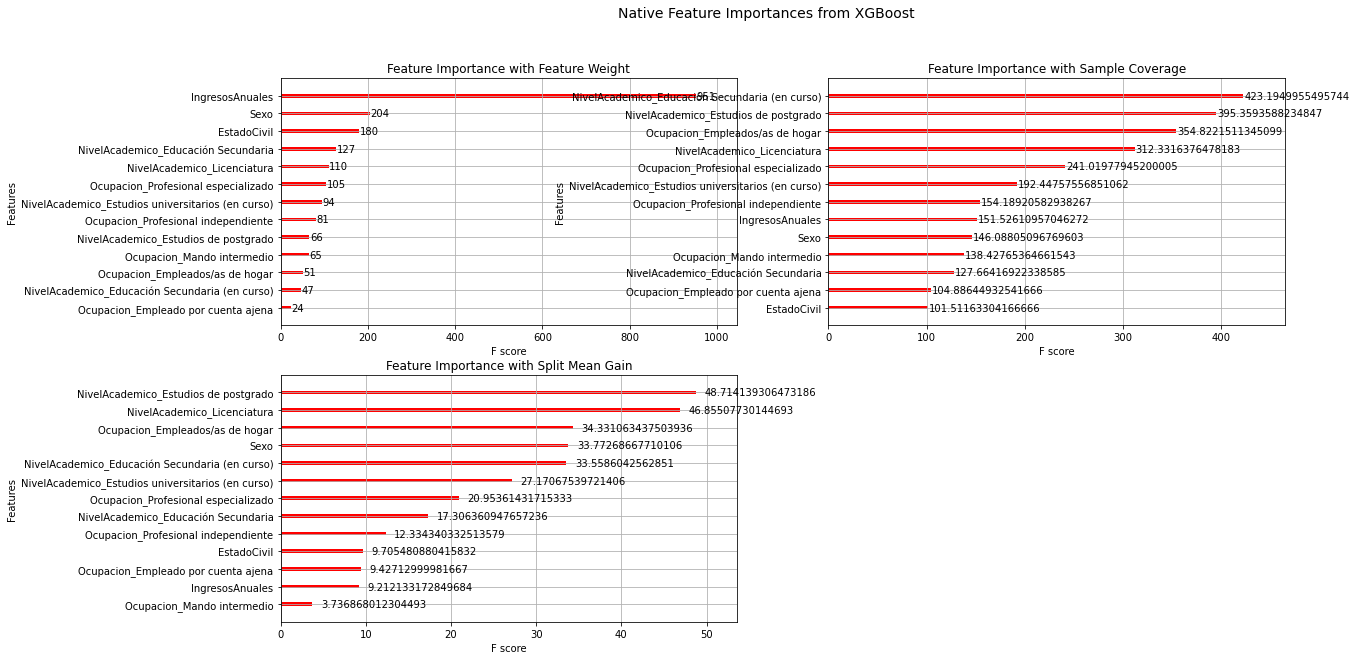

In [29]:
fig = plt.figure(figsize = (18, 10))
title = fig.suptitle("Native Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2, 2, 1)
plot_importance(xgb, importance_type='weight', ax=ax1, color='red')
ax1.set_title("Feature Importance with Feature Weight");

ax2 = fig.add_subplot(2, 2, 2)
plot_importance(xgb, importance_type='cover', ax=ax2, color='red')
ax2.set_title("Feature Importance with Sample Coverage");

ax3 = fig.add_subplot(2, 2, 3)
plot_importance(xgb, importance_type='gain', ax=ax3, color='red')
ax3.set_title("Feature Importance with Split Mean Gain");

# Permutación de Importancia de Características

independiente de Modelo



In [24]:
from sklearn.inspection import permutation_importance

Feature: 0, Score: 0.04351
Feature: 1, Score: 0.08009
Feature: 2, Score: 0.19005
Feature: 3, Score: 0.04383
Feature: 4, Score: 0.01458
Feature: 5, Score: 0.07908
Feature: 6, Score: 0.07306
Feature: 7, Score: 0.25894
Feature: 8, Score: 0.01095
Feature: 9, Score: 0.01768
Feature: 10, Score: 0.00877
Feature: 11, Score: 0.09898
Feature: 12, Score: 0.03057


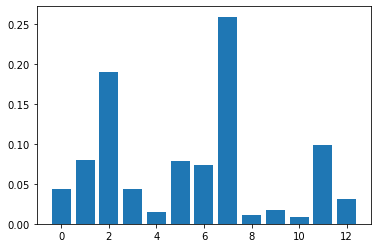

In [25]:
resultados = permutation_importance(clf, X_trainres, y_trainres, scoring='neg_mean_squared_error')

importancia = resultados.importances_mean

for i,v in enumerate(importancia):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importancia))], importancia)
pyplot.show()

# Interpretación con ELI5

 ELI5 ("Explain Like I'm 5") es una librería Python que nos ayuda a depurar clasificadores y regresores. Soporta modelos paramétricos y lineales, también no paramétricos y procesamiento de textos pero no es agnóstica al modelo

In [ ]:
!pip install eli5

In [30]:
import eli5
from eli5.sklearn import PermutationImportance

In [31]:
# usa el predeterminado de XGBoost con Gain
eli5.show_weights(xgb.get_booster())

Weight,Feature
0.1586,NivelAcademico_Estudios de postgrado
0.1526,NivelAcademico_Licenciatura
0.1118,Ocupacion_Empleados/as de hogar
0.1100,Sexo
0.1093,NivelAcademico_Educación Secundaria (en curso)
0.0885,NivelAcademico_Estudios universitarios (en curso)
0.0682,Ocupacion_Profesional especializado
0.0564,NivelAcademico_Educación Secundaria
0.0402,Ocupacion_Profesional independiente
0.0316,EstadoCivil


In [32]:


ocurrencia=0
print('Referencia:', y_testres.iloc[ocurrencia])
print('Predicted:', xgb_predictions[ocurrencia])
eli5.show_prediction(xgb.get_booster(), X_testres.iloc[ocurrencia], 
                     feature_names=list(X_testres.columns), show_feature_values=True)

Referencia: 0
Predicted: 0
